## CREATE AUGMENTATION SAMPLE


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms, models

In [3]:
path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
os.chdir(path)
print(path)

/content/drive/MyDrive/Colab Notebooks


In [4]:
SEED =  12321
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

### Helper functions

In [5]:
def plot_histogram(data, plot_properties):
  """ Generic function to plot a histogram.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.hist(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()


def plot_box(data, plot_properties):
  """ Generic function to plot a box plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.boxplot(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()
    
def plot_count(data,plot_properties):
    """ Generic for a count plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":"", "x":""}
    """
    plt.figure(figsize=(10, 6))
    chart = sns.countplot(data,x=plot_properties['x'],palette='Set2')
    chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=45, horizontalalignment='right')
    plt.title(plot_properties["title"])
    plt.xlabel(plot_properties["xlabel"])
    plt.ylabel(plot_properties["ylabel"])
    plt.show()

def exploring_new_dataset(dataset):
  """ This function performs the role of
      displaying the common information about a dataset
  """
  print("Sample length",len(dataset))
  print(dataset.groupby('target').image_name.count())
  plot_count(dataset.benign_malignant, 
               {"title":"IMAGES BY GROUND TRUTH",
                "xlabel":"TARGET","ylabel":"NUMBER OF IMAGES","x":"target"})


In [6]:
def get_sample_from_df(sample,n):
    for i in list(range(n,0, -1)):
        if len(sample)>=i:
            return sample.sample(n=i, random_state=SEED).index[:i]
        
    return [];


def sample_by_patient(dataset,num_sample=1):
  """ Get patient id as category
   Prepare two datasets:
   for each patient_id
       select get records
         if malignant
           sample num_sample
         elif benign
           sample num_sample"""
  unique_patient_id = dataset.patient_id.cat.categories
  malignant_df = dataset[dataset['target'] == 1]
  benign_df = dataset[dataset['target'] == 0]
  sample_indices = []
  #samples per patient
  for  patient_id in unique_patient_id:
      patient_sample = malignant_df[malignant_df['patient_id']==patient_id]
      if len(patient_sample):
          sample_indices.extend(get_sample_from_df(patient_sample,num_sample))
      else:
          patient_sample = benign_df[benign_df['patient_id']==patient_id]
          sample_indices.extend(get_sample_from_df(patient_sample,num_sample))

  return dataset.loc[sample_indices]

def perform_sampling(dataset,sampling_type="", patient_group_sample=1):
  """function to perform sampling based on
     the sampling type provided.
     Return train, test dataset
  """
  train = None
  test = None
  if sampling_type=="PATIENT_GROUP":
    sample=sample_by_patient(dataset,patient_group_sample)
    train, test = train_test_split(sample, test_size=0.2, shuffle=True, random_state=SEED)
  else:
    # default train_test split by 8:2
    train, test = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED)

  return train,test;   


In [7]:
def set_image_file_name(row,base_path):
    """We create the image file name"""
    file = row["image_name"]+".jpg"
    file_path = os.path.join(base_path, file)
    return file_path if os.path.exists(file_path) else np.nan

def create_benign_malignant_column(row):
    """Create benign and malignant classes from HAM10000"""
    if(row['dx']=="mel"):
      return "malignant"
    if(row['dx']=="bkl"):
      return "malignant"
    if(row['dx']=="bcc"):
      return "malignant"     
    elif row['dx']=="nv":
      return "benign"
    else:    
     return np.nan    

### Load the dataset
We load the train.csv dataset csv. Then perform the following:




In [8]:
isic_siim_df = pd.read_csv("aug_sample.csv")
isic_siim_df.head()

,image_name,benign_malignant,target,images
0,aug/AUG_ISIC_0030659,malignant,1,aug/AUG_ISIC_0030659.jpg
1,aug/AUG_ISIC_0029193,malignant,1,aug/AUG_ISIC_0029193.jpg
2,aug/AUG_ISIC_0032358,malignant,1,aug/AUG_ISIC_0032358.jpg
3,aug/AUG_ISIC_0024701,malignant,1,aug/AUG_ISIC_0024701.jpg
4,aug/AUG_ISIC_0031945,malignant,1,aug/AUG_ISIC_0031945.jpg


### Preprocessing of the dataset


In [9]:
print("The number of rows and columne in train.csv: {}".format(isic_siim_df.shape))
print(isic_siim_df.columns)
print("\nDATA TYPES\n")
print(isic_siim_df.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(isic_siim_df.count())
print("\nNULL COUNT\n")
print(isic_siim_df.isnull().sum())
# isic_siim_df.dropna(axis=0, inplace=True)

The number of rows and columne in train.csv: (11000, 4)
Index(['image_name', 'benign_malignant', 'target', 'images'], dtype='object')

DATA TYPES

image_name          object
benign_malignant    object
target               int64
images              object
dtype: object



COLUMN COUNT

image_name          11000
benign_malignant    11000
target              11000
images              11000
dtype: int64

NULL COUNT

image_name          0
benign_malignant    0
target              0
images              0
dtype: int64


In [10]:
isic_siim_df = isic_siim_df.astype({'benign_malignant':'category',
                             'target':'category'})

Sample length 11000
target
0    7700
1    3300
Name: image_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


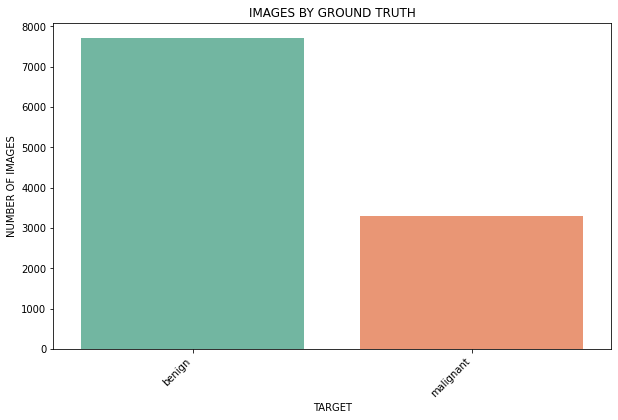

In [11]:
exploring_new_dataset(isic_siim_df)

In [13]:
train, test = perform_sampling(isic_siim_df)

**Train datasets**


ISIC SIIM TRAIN SET

Sample length 8800
target
0    6174
1    2626
Name: image_name, dtype: int64


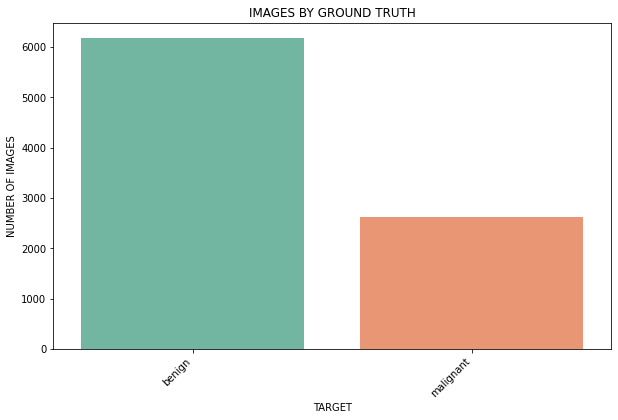

In [14]:
print('\nISIC SIIM TRAIN SET\n')
exploring_new_dataset(train)

**Test dataset**


ISIC SIIM TEST SET

Sample length 2200
target
0    1526
1     674
Name: image_name, dtype: int64


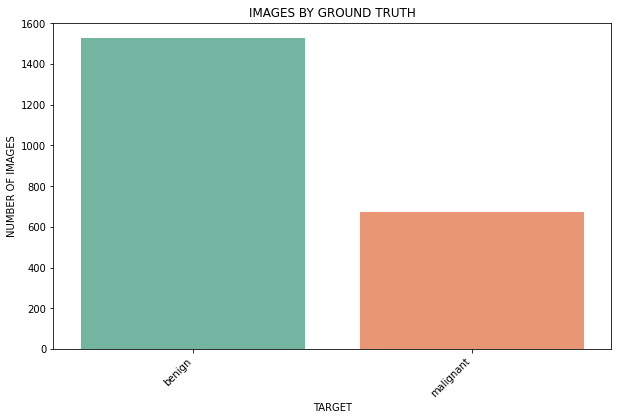

In [15]:
print('\nISIC SIIM TEST SET\n')
exploring_new_dataset(test)

### Export to csv

In [16]:
train.to_csv('aug_train_sample.csv',index=False)

In [17]:
test.to_csv('aug_test_sample.csv',index=False)